##  Lane Segmentation  using a Fully Convolutional Network

#1. Data Loading and Preprocessing

In [1]:
# Upload data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/colabdataset/dataset_camVid.zip

Archive:  /content/drive/MyDrive/colabdataset/dataset_camVid.zip
  inflating: data/CamVid/train/0001TP_006690.png  
  inflating: data/CamVid/train/0001TP_006720.png  
  inflating: data/CamVid/train/0001TP_006750.png  
  inflating: data/CamVid/train/0001TP_006780.png  
  inflating: data/CamVid/train/0001TP_006810.png  
  inflating: data/CamVid/train/0001TP_006840.png  
  inflating: data/CamVid/train/0001TP_006870.png  
  inflating: data/CamVid/train/0001TP_006900.png  
  inflating: data/CamVid/train/0001TP_006930.png  
  inflating: data/CamVid/train/0001TP_006960.png  
  inflating: data/CamVid/train/0001TP_006990.png  
  inflating: data/CamVid/train/0001TP_007020.png  
  inflating: data/CamVid/train/0001TP_007050.png  
  inflating: data/CamVid/train/0001TP_007080.png  
  inflating: data/CamVid/train/0001TP_007110.png  
  inflating: data/CamVid/train/0001TP_007140.png  
  inflating: data/CamVid/train/0001TP_007170.png  
  inflating: data/CamVid/train/0001TP_007200.png  
  inflating: data

In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from random import random

# import pytorch related modules
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize

from torch.nn import Sequential
from torch.nn import Conv2d, ReLU, Sigmoid, BatchNorm2d, Dropout

from torchvision.models.segmentation import fcn_resnet101

In [4]:
#Defining the directory path for train , validation images
x_train_dir = '/content/data/CamVid/train'
y_train_dir = '/content/data/CamVid/trainannot'

x_val_dir = '/content/data/CamVid/val'
y_val_dir = '/content/data/CamVid/valannot'

x_test_dir = '/content/data/CamVid/test'
y_test_dir = '/content/data/CamVid/testannot'

In [5]:
# define custom dataset class
class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, training_type=None):
        # get all image names
        self.image_names = os.listdir(images_dir)

        # set training type, transforms
        self.training_type = training_type
        self.transforms = transforms

        # get image and target paths
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type=="train" or self.training_type=="val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))

    def __getitem__(self, i):

        if self.training_type=="train" or self.training_type=="val":
            # read data
            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # preprocess mask
            mask = np.array(mask)
            mask = (mask == 3)
            mask = Image.fromarray(mask)

            # apply transforms
            image = self.transforms(image)
            mask = self.transforms(mask)

            return image, mask

        else:
            # read data
            image = Image.open(self.images_paths[i])

            # apply transforms
            image = self.transforms(image)

            return image

    def __len__(self):
        return len(self.image_names)

In [6]:
# create transform
train_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
# create instance of custom dataset
train_dataset = CamVidDataset(
    x_train_dir,
    y_train_dir,
    transforms=train_transforms,
    training_type='train'
)

# create dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


- train_transforms :  defines a set of image transformations using the torchvision.transforms.Compose class. These transformations are commonly used when preparing images for training a deep learning model.
  1. Resize((224, 224)): This transformation resizes the input image to a specified size. In this case, it resizes the image to a square of size 224x224 pixels.
  2. ToTensor(): This transformation converts the input image (which is a NumPy array or PIL Image) into a PyTorch tensor. PyTorch tensors are the primary data structure used for representing data in PyTorch<br>
  By combining these transformations into a Compose object, you can apply them sequentially to an input image.

- train_dataset: creates a train_dataset object, which is an instance of the CamVidDataset class.
  - x_train_dir: This is the directory containing the input images for training.
  - y_train_dir: This is the directory containing the corresponding mask images (targets) for training.
  - transforms=train_transforms: This specifies the image transformations to be applied to the input images and mask images. These transformations were defined earlier as train_transforms.
  -training_type='train': This specifies the type of dataset, which is 'train' in this case. This information is used internally in the CamVidDataset class to determine how to process the data (e.g., whether to load mask images or not).<br> <br>
Overall, this train_dataset object is configured to load and preprocess the training data (input images and mask images) from the specified directories, applying the specified transformations.
- train_dataloader: This code creates a DataLoader object for the train_dataset, which is an instance of the CamVidDataset class. The DataLoader is a utility in PyTorch that helps iterate over a dataset in batches. Here's a breakdown of the parameters used:
  - train_dataset: The dataset from which to load the data.
  - batch_size=16: The number of samples in each batch. In this case, each batch will contain 16 samples (16 images and their corresponding masks).
  - num_workers=4: The number of subprocesses to use for data loading. This parameter can speed up data loading by parallelizing the process. Here, 4 subprocesses will be used to load the data.

# Visualisation of single transformed image and its mask  from train dataset


In [7]:
image, gt_mask = train_dataset[0]
image.shape, gt_mask.shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

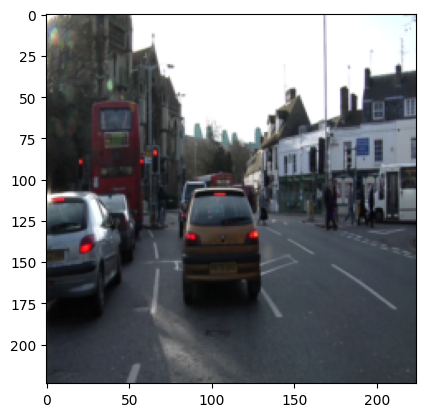

In [8]:
plt.imshow(np.transpose(image, (1, 2, 0)))

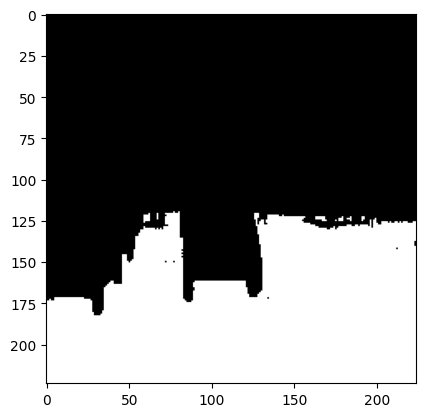

In [9]:
plt.imshow(gt_mask.squeeze(), cmap='gray')

# Iterating over the batches of train_dataloader

In [10]:
for batch_x, batch_y in train_loader:
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [11]:
batch_x.shape, batch_y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1, 224, 224]))

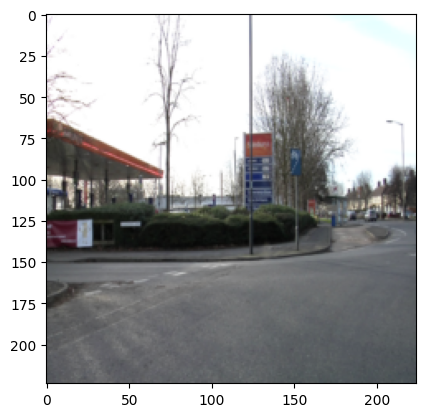

In [12]:
# Assuming batch_x is a batch of images
plt.imshow(batch_x[5].permute(1, 2, 0))
plt.show()

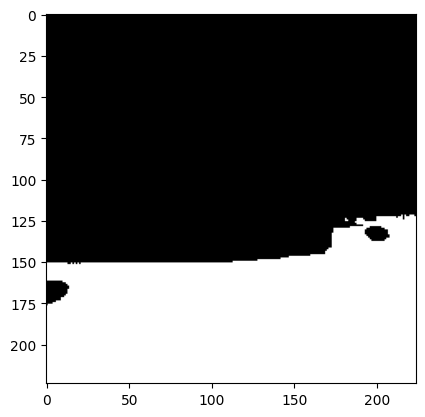

In [13]:
# Assuming batch_x is a batch of images
plt.imshow(batch_y[5].permute(1, 2, 0),cmap='gray')
plt.show()

- Each batch will contain two tensors: one for the input images and one for the corresponding masks, each with a shape of (batch_size, channels, height, width), where batch_size is 16 in this case, channels is the number of channels in the image (e.g., 3 for RGB), and height and width are the dimensions of the image.

## 2. Lane segmentation using FCN

# 2.1  Define FCN Model

In [14]:
# define model
model = fcn_resnet101(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:02<00:00, 74.5MB/s]


In [15]:
# print model
model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [16]:
model.classifier

FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
)

In [17]:
# freeze model parameters
for parameters in model.parameters():
    parameters.requires_grad = False

In [18]:
model.classifier = Sequential(
    Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    ReLU(),
    Dropout(p=0.1, inplace=False),
    Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1)),
    Sigmoid()
)

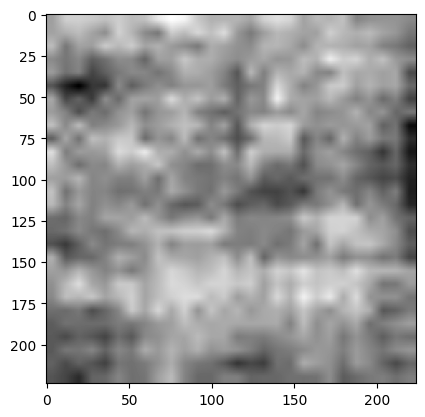

In [19]:
# check model on one image
model.eval()
output = model(batch_x[5].view(1, 3, 224, 224))['out'].detach().numpy()
# print output
plt.imshow(output.squeeze(),cmap='gray')

#2.2 Train the model

In [20]:
# transfer model to GPU
model = model.to("cuda")

In [21]:
# define optimization and loss function
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3)

In [23]:
# set model to train
model.train()

# train model
for epoch in range(5):

    # initialize variables
    epoch_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in train_loader:
        # get batch images and targets and transfer them to GPU
        batch_x = batch_x.to("cuda").float()
        batch_y = batch_y.to("cuda").float()

        # clear gradients
        optimizer.zero_grad()

        # pass images to model
        outputs = model(batch_x)

        # get loss
        loss = criterion(outputs['out'], batch_y)

        # do a backward pass
        loss.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_loss += loss.item()
        cnt += 1

    # take average loss for all batches
    epoch_loss /= cnt

    # print loss
    print("Training loss for epoch {} is {} ".format(epoch + 1, epoch_loss))

Training loss for epoch 1 is 0.06253025275857552 
Training loss for epoch 2 is 0.058119605254867805 
Training loss for epoch 3 is 0.054676466661950814 
Training loss for epoch 4 is 0.05167799604975659 
Training loss for epoch 5 is 0.0491296895172285 


# 2.3 Calculate IOU score

In [24]:
# get sample data
image1 = Image.open('/content/data/CamVid/train/0001TP_006990.png')
gt_mask1 = Image.open('/content/data/CamVid/trainannot/0001TP_006990.png')

In [ ]:
# preprocess mask
gt_mask = np.array(gt_mask1)
gt_mask = (gt_mask1 == 3)
gt_mask = Image.fromarray(gt_mask1)

# apply data augmentation
transform = Compose([
            Resize((224, 224)),
            ToTensor()
            ])

image = transform(image1)

gt_mask = transform(gt_mask)

In [26]:
model.eval()
output1 = model(image.view(1, 3, 224, 224).to("cuda"))['out'].cpu().detach().numpy()

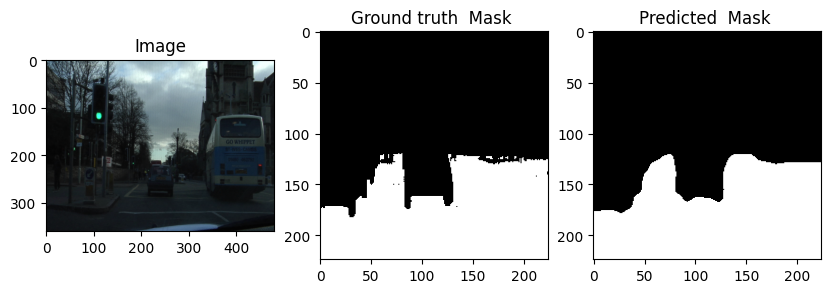

In [28]:
plt.figure(figsize=(10, 5))

# Display the Image in the first subplot
plt.subplot(1, 3, 1)
plt.imshow(image1)
plt.title('Image')

# Display the image ground truth mask in the second subplot
plt.subplot(1, 3, 2)
plt.imshow(gt_mask.squeeze(), cmap='gray')
plt.title('Ground truth  Mask ')

# Display the predicted mask in the second subplot
plt.subplot(1, 3, 3)
plt.imshow((output1.squeeze() > 0.5).astype(int), cmap='gray')
plt.title('Predicted  Mask ')

plt.show()

In [30]:
# Calculating IOU score
# convert predicted mask to flattened numpy array
mask = (output1.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

# convert ground truth mask to flattened numpy array
gt_mask = gt_mask.cpu().detach().numpy()
target = gt_mask.ravel().copy().astype(int)

# get class indices for Lane
pred_inds = pred == 1
target_inds = target == 1

# calculate intersection
intersection = pred_inds[target_inds].sum()

# calculate union
union = pred_inds.sum() + target_inds.sum() - intersection

# get IoU score
iou = (float(intersection) / float(max(union, 1)))
iou

0.9472672342762977

## 3.Predict mask from validation data

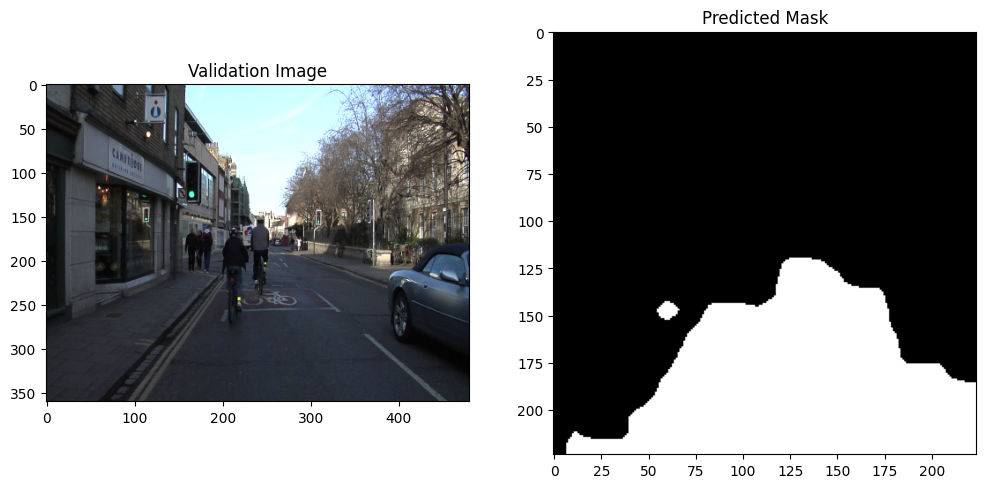

In [40]:
val_image =Image.open('/content/data/CamVid/val/0016E5_08053.png')
# apply data augmentation
transform = Compose([
            Resize((224, 224)),
            ToTensor()
            ])

test_image = transform(val_image)
model.eval()
output_test = model(test_image.view(1, 3, 224, 224).to("cuda"))['out'].cpu().detach().numpy()
predicted_mask =(output_test.squeeze()>0.5).astype(int)

# Visualize the prediction
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(val_image)
plt.title('Validation Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')

plt.show()
